In [1]:
%run Structure.ipynb
%run Aero.ipynb
from types import SimpleNamespace

# this is hamilton's quaternion product
def product(a, b):
    v = b[0] * a[1:] + a[0] * b[1:] + np.cross(a[1:], b[1:])
    return np.array([a[0] * b[0] - np.dot(a[1:], b[1:]), v[0], v[1], v[2]])

# this is the inverse of a unit quat
def conjugate(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])

# this rotates a vector with a fixed frame
def sandwich(q, v):
    return product(q, product(np.array([0, v[0], v[1], v[2]]), conjugate(q)))[1:]

# this rotates a frame with a fixed vector
def frame_rotation(q, v):
    return sandwich(conjugate(q), v)

# this constrains a quat to S3
def normalize(q):
    norm = np.linalg.norm(q)
    norm = norm if norm !=0 else 1
    return q / norm

In [2]:
class Environment():
    def __init__(self, aero_model, latitude=32):
        self.ka = 1.4                   # Ratio of specific heats, air  
        self.Ra = 287.058                 # Avg. specific gas constant (dry air)
        self.latitude = np.radians(latitude) # degrees north, launch site
        # International Gravity Formula (IGF) 1980, Geodetic Reference System 1980 (GRS80)
        self.IGF = 9.780327 * (1 + 0.0053024 * np.sin(self.latitude)**2 - 0.0000058 * np.sin(2*self.latitude)**2)
        # Free Air Correction (FAC)
        self.FAC = -3.086 * 10**(-6)
        self.sinlat = np.sin(self.latitude)
        self.coslat = np.cos(self.latitude)
        self.erot = 7.2921150e-5 # Sidearial Earth rotation rate
        #openrocket method, open rocket uses 6371000 for earth radius
        sin2lat = self.sinlat**2
        self.g_0 = 9.7803267714 * ((1.0 + 0.00193185138639 * sin2lat) / np.sqrt(1.0 - 0.00669437999013 * sin2lat))
        self.aero_model = aero_model
        
        T_0 = 288.15 # K
        p_0 = 101325 # Pa
        self.layer =  [0, 11000, 20000, 32000, 47000, 51000, 71000, 84852,
                       90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000]
        self.baseTemp = [288.15, 216.65, 216.65, 228.65, 270.65, 270.65, 214.65, 186.95,
                         196.86, 203.06, 224.28, 250.09, 285.13, 364.19, 441.79, 517.94]
        self.basePress = [p_0]
        for i, alt in enumerate(self.layer):
            if i == 0:
                pass
            else:
                self.basePress.append(self.getConditions(self.layer[i]-1)[1])
    # https://github.com/openrocket/openrocket/blob/b5cde10824440a1e125067b7d149873deec424b4/core/src/net/sf/openrocket/util/GeodeticComputationStrategy.java
    def coriolis(self, v):
        v_n = v[1]
        v_e = -v[0]
        v_u = v[2]
        acc = np.array([2*self.erot*(v_n*self.sinlat - v_u*self.coslat),
                        2*self.erot*(-v_e*self.sinlat),
                        2*self.erot*(v_e*self.coslat)])
        return acc
    # https://www.sensorsone.com/local-gravity-calculator/
    # maybe one day i'll use this alternative https://github.com/openrocket/openrocket/blob/unstable/core/src/net/sf/openrocket/models/gravity/WGSGravityModel.java
    def g_accel(self, x):
        #return self.IGF + self.FAC * x[-1]
        return self.g_0 * (6356766/(6356766 + x[-1]))**2
    # U.S. 1976 Standard Atmosphere, pls sanity check eventually
    def old_std_at(self, x):
        if x[2] < 11000:
            T = 15.04 - 0.00649*x[2]
            p = 101.29*((T + 273.1)/288.08)**5.256
    
        elif 11000 <= x[2] and x[2] <25000:
            T = -56.46
            p = 22.65*np.exp(1.73 - 0.000157*x[2])
    
        else:
            T = -131.21 + 0.00299*x[2]
            p = 2.488 * ((T + 273.1)/216.6)**(-11.388)
    
        p_a = p*1000                 # Ambient air pressure [Pa]
        rho = p/(0.2869*(T + 273.1)) # Ambient air density [kg/m^3]
        T_a = T + 273.1              # Ambient air temperature [K]
        return np.array([p_a, rho, T_a])
    def getConditions(self, altitude):
        index = 0
        g = self.g_accel([altitude])
        altitude = altitude * 6356766 / (altitude + 6356766) # geopotential altitude
        for i in range(len(self.layer)-1):
            if self.layer[i + 1] > altitude:
                break
            index += 1
        rate = (self.baseTemp[index+1] - self.baseTemp[index])/(self.layer[index+1] - self.layer[index])
        t = self.baseTemp[index] + (altitude - self.layer[index])* rate
        if altitude > 95000:
            Ra = R_univ / 25
        else:
            Ra = self.Ra
        #p = self.basePress[0]*np.exp(-self.g_accel([altitude])*altitude/(t*Ra))
        if abs(rate) > 0.001:
            p = self.basePress[index]*(1 + (altitude-self.layer[index])*rate/self.baseTemp[index])**(-g/(rate*Ra))
        else:
            p = self.basePress[index]*(np.exp(-(altitude-self.layer[index])* g / (Ra * self.baseTemp[index])))
        return (t, p)
    
    def std_at(self, x):
        T_a, p_a = self.getConditions(x[-1])
        if self.Ra == 287.058 and x[-1] > 95000:
            self.Ra = R_univ / 25 # rough estimate when you care, see
            # Miller, L. E. (1957). “Molecular weight” of air at high altitudes

        rho = p_a/(self.Ra*T_a) # Ambient air density [kg/m^3]
        mu = 3.7291*10**-6 + 4.9944*10**-8 * T_a / rho # kinematic wiscosity
        return np.array([p_a, rho, T_a, mu])
    
    # calculates drag force, etc
    def aero(self, x, q, v, w, rkt, air, wind):
        rho = air[1]
        T_a = air[2]
        # Check Knudsen number and consider other drag models (e.g. rarified gas dyn vs. quadratic drag)
        v0 = np.linalg.norm(v-wind)
        v_hat = normalize(v - wind)
        v_body = frame_rotation(q, v_hat)
        up = np.array([0,0,1])
        alpha = np.arccos(min(np.dot(v_body, up), 1)) # kludge to escape floating point errors...
        #Ma = v0 / np.sqrt(self.ka * self.Ra * T_a) # Mach
        Ma = v0 / (165.77 + 0.606*T_a) # openrocket
        dyn_press = 0.5 * rho * v0**2         # Dynamic pressure [Pa]
        roll = w[2]
        
        CoP, CN, CDax, Cld_times_d = self.aero_model.physics(alpha, Ma, v0, roll, air[3])
        CoP = np.array([0,0, rkt.length - CoP])
        stability_margin = (rkt.CoM[2] - CoP[2])/rkt.diameter
        
        direction = -normalize((np.identity(3) - np.outer(up, up)).dot(v_body))
        norm_force= CN*direction
        
        if not rkt.off_tower:#np.linalg.norm(x-np.array([0,0,1401])) < 18.288:
            norm_force*=0
            Cld_times_d=0
        force_body = (np.array([0,0,-CDax]) + norm_force) * dyn_press * rkt.frontal_area
        torque_body = (np.array([0,0, -Cld_times_d]) +
                       np.cross(CoP - rkt.CoM, norm_force) +
                       np.array([np.random.uniform(-0.0005,0.0005),
                                np.random.uniform(-0.0005,0.0005),0])) * dyn_press * rkt.frontal_area
        
        num_thrusters = 0
        if rcs_control and rkt.has_spare_gas():
            up_body = frame_rotation(q, up)
            if np.arccos(min(np.dot(up_body, up), 1)) >= 0.00872665:
                sign_vec = -np.sign((np.cross(up, np.cross(up, up_body))))
                xaxis = np.array([sign_vec[0], 0, 0])
                yaxis = np.array([0, sign_vec[1], 0])
                num_thrusters = abs(xaxis[0]) + abs(yaxis[1])
                rcs_thrust = rkt.rcs.parts[1].thrust(air[0], 1)
                forcex = xaxis*rcs_thrust
                forcey = yaxis*rcs_thrust
                force_body += forcex + forcey
                xaxis = rkt.inr_r*xaxis + (rkt.rcs.lever_arm - rkt.CoM)
                yaxis = rkt.inr_r*yaxis + (rkt.rcs.lever_arm - rkt.CoM)
                torquex = np.cross(xaxis, forcex)
                torquey = np.cross(yaxis, forcey)
                torque_body += torquex + torquey
            
        force = sandwich(q, force_body)
        return np.array([force, torque_body, v0, dyn_press, Ma, alpha, stability_margin, num_thrusters, rkt.CoM[2] , CoP[2]])

# state = [m, x, q, v, w], is it an issue that our CoM changes but we still use F=MA?
# parameters = [mdot, thtl, I_body, forces, torques], is it a sin to not update MoI as a state variable?
# reference (7.233) on page 435 of Shabana for dynamical equations
def ODE(state, parameters):
    def dm_dt(mdot, throttle):
        return -mdot*throttle
    # kinematic equations of motion
    def dx_dt(v):
        return v
    def dq_dt(q, w):
        return 1/2 * product(q, np.array([0, w[0], w[1], w[2]]))
    # dynamical equations of motion
    def dv_dt(q, mass, forces):
        return (sandwich(q, [0,0,1])*forces[0] + forces[1])/mass - np.array([0,0,forces[2]]) + forces[3]
    def dw_dt(I_body, w, torques):
        return np.linalg.inv(I_body).dot(sum(torques) - np.cross(w, I_body.dot(w)))
    return np.array([dm_dt(parameters[0], parameters[1]),
            dx_dt(state[3]),
            dq_dt(state[2], state[4]),
            dv_dt(state[2], state[0], parameters[3]),
            dw_dt(parameters[2], state[4], parameters[4])])

# get Cd from barrowman
def Forces(env, rkt, state, param):
    air = env.std_at(state[1])
    grav = env.g_accel(state[1])
    aero = env.aero(state[1], state[2], state[3], state[4], rkt, air, np.array([0,0,0]))
    if rkt.has_fuel():
        throttle = rkt.engine.throttle_engine(np.linalg.norm(aero[0]))
        thrust = rkt.engine.thrust(air[0], throttle)
    else:
        throttle = 0.
        thrust = 0.
    return (np.array([thrust, aero[0], grav, env.coriolis(state[3])]), throttle, air, aero)

# gravitational torque. inputs in inertial frame, outputs in body frame
def T_gg(r_I, attitude_BI, J):
    mu = 3.986004418 * 10**14 # m^3/s^2
    x = r_I # m
    r = np.linalg.norm(x)
    actual = r + 6371000
    n = frame_rotation(attitude_BI, - x / r)
    return (3 * mu / actual**3) * np.cross(n, J.dot(n)) # kg * m^2 / s^2

def Torques(state, parameters, aero_T):
    T= T_gg(state[1], state[2], parameters)
    return [T, aero_T]

# parameters = [C_d, T_param]
def runge_kutta(env, rkt, state, parameters, dt):
    mdot = rkt.parts[1].parts[0].mdot if rkt.has_fuel() else 0
    F1 = Forces(env, rkt, state, parameters[0])
    T1 = Torques(state, parameters[1], F1[3][1])
    k1 = ODE(state, [mdot, F1[1], rkt.moment, F1[0], T1])
    
    state_2 = [sum(pair) for pair in zip(state, dt*k1/2)]
    state_2[2] = normalize(state_2[2])
    F2 = Forces(env, rkt, state_2, parameters[0])
    T2 = Torques(state_2, parameters[1], F2[3][1])
    k2 = ODE(state_2, [mdot, F2[1], rkt.moment, F2[0], T2])
    
    state_3 = [sum(pair) for pair in zip(state, dt*k2/2)]
    state_3[2] = normalize(state_3[2])
    F3 = Forces(env, rkt, state_3, parameters[0])
    T3 = Torques(state_3, parameters[1], F3[3][1])
    k3 = ODE(state_3, [mdot, F3[1], rkt.moment, F3[0], T3])
    
    state_4 = [sum(pair) for pair in zip(state, dt*k3)]
    state_4[2] = normalize(state_4[2])
    F4 = Forces(env, rkt, state_4, parameters[0])
    T4 = Torques(state_4, parameters[1], F4[3][1])
    k4 = ODE(state_4, [mdot, F4[1], rkt.moment, F4[0], T4])
    
    return ((k1 + 2*k2 + 2*k3 + k4)/6,
            (F1[0] + 2*F2[0] + 2*F3[0] + F4[0])/6,
            (F1[1] + 2*F2[1] + 2*F3[1] + F4[1])/6,
            (F1[2] + 2*F2[2] + 2*F3[2] + F4[2])/6,
            (F1[3][3:] + 2*F2[3][3:] + 2*F3[3][3:] + F4[3][3:])/6,
            None)

# parameters = [C_d, T_param]
# http://maths.cnam.fr/IMG/pdf/RungeKuttaFehlbergProof.pdf
def adaptive_runge_kutta(env, rkt, state, parameters, dt):
    mdot = rkt.parts[1].parts[0].mdot if rkt.has_fuel() else 0
    F1 = Forces(env, rkt, state, parameters[0])
    T1 = Torques(state, parameters[1], F1[3][1])
    k1 = ODE(state, [mdot, F1[1], rkt.moment, F1[0], T1])
    
    state_2 = [sum(pair) for pair in zip(state, dt[-1]*k1/4)]
    state_2[2] = normalize(state_2[2])
    F2 = Forces(env, rkt, state_2, parameters[0])
    T2 = Torques(state_2, parameters[1], F2[3][1])
    k2 = ODE(state_2, [mdot, F2[1], rkt.moment, F2[0], T2])
    
    state_3 = [sum(pair) for pair in zip(state, dt[-1] *(
                                         3*k1 + 9*k2)/32)]
    state_3[2] = normalize(state_3[2])
    F3 = Forces(env, rkt, state_3, parameters[0])
    T3 = Torques(state_3, parameters[1], F3[3][1])
    k3 = ODE(state_3, [mdot, F3[1], rkt.moment, F3[0], T3])
    
    state_4 = [sum(pair) for pair in zip(state, dt[-1]*(
        1932*k1 - 7200*k2 + 7296*k3)/2197)]
    state_4[2] = normalize(state_4[2])
    F4 = Forces(env, rkt, state_4, parameters[0])
    T4 = Torques(state_4, parameters[1], F4[3][1])
    k4 = ODE(state_4, [mdot, F4[1], rkt.moment, F4[0], T4])
    
    state_5 = [sum(pair) for pair in zip(state, dt[-1]*(
        439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104))]
    state_5[2] = normalize(state_5[2])
    F5 = Forces(env, rkt, state_5, parameters[0])
    T5 = Torques(state_5, parameters[1], F5[3][1])
    k5 = ODE(state_5, [mdot, F5[1], rkt.moment, F5[0], T5])
    
    state_6 = [sum(pair) for pair in zip(state, dt[-1]*(
        -8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40))]
    state_6[2] = normalize(state_6[2])
    F6 = Forces(env, rkt, state_6, parameters[0])
    T6 = Torques(state_6, parameters[1], F6[3][1])
    k6 = ODE(state_6, [mdot, F6[1], rkt.moment, F6[0], T6])
    
    order_5 = state + dt[-1] * (
        16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55)
    order_5[2] = normalize(order_5[2])
    return (25*k1/216 + 1408*k3/2565 + 2197*k4/4101 - k5/5,
            25*F1[0]/216 + 1408*F3[0]/2565 + 2197*F4[0]/4101 - F5[0]/5,
            25*F1[1]/216 + 1408*F3[1]/2565 + 2197*F4[1]/4101 - F5[1]/5,
            25*F1[2]/216 + 1408*F3[2]/2565 + 2197*F4[2]/4101 - F5[2]/5,
            25*F1[3][3:]/216 + 1408*F3[3][3:]/2565 + 2197*F4[3][3:]/4101 - F5[3][3:]/5,
           order_5)

def time_step(env, rkt, state, parameters, dt, state_list):
    if rkt.adaptive:
        update = adaptive_runge_kutta(env, rkt, state, parameters, dt)
    else:
        update = runge_kutta(env, rkt, state, parameters, dt)
    new = state + dt[-1] * update[0]
    new[2] = normalize(new[2])
    
    if (np.linalg.norm(new[1] - state_list[0][0][1]) >= launch_tower and
        np.linalg.norm(state[1] - state_list[0][0][1]) < launch_tower):
        rkt.off_tower = True
        rkt.tower_index = len(state_list)+1
        rkt.launch_speed = np.linalg.norm(new[3])
    if rkt.has_fuel():
        rkt.kludge = True
    else:
        if rkt.kludge:
            rkt.kludge = False
            rkt.F_index = len(state_list) - 1
    
    rkt.rcs.parts[0].drain(update[4][4]*rkt.rcs.mdot * dt[-1])
    rkt.rcs.parts[1].exhaust_velocity(rkt.rcs.pressure())
    
    del_m_o, del_m_f = proportion(dt[-1]*update[0][0], rkt.OF)
    rkt.lox_tank.drain(del_m_o)
    rkt.ipa_tank.drain(del_m_f)
    rkt.sum_parts()
    
    if not rkt.adaptive:
        m_prop = rkt.lox_tank.parts[-1].mass + rkt.ipa_tank.parts[-1].mass
        rkt.eng_sys.sum_parts()
        openrocket_CoM = rkt.eng_sys.CoM[2] # rkt.length - 
    else:
        m_prop, openrocket_CoM = None, None
    
    if rkt.adaptive:
        diff = 2 * sqrt(sum([np.linalg.norm(i)**2 for i in (update[-1] - new)]))
        rkt.error.append(diff/2)
        dt.append(dt[-1] * (rkt.tol/diff)**.25)
     
    state_list.append((new, update[0][3], update[1:-1], m_prop, openrocket_CoM))

def integration(env, rkt, dt):
    stop = False
    env.first_time_env = True
    rkt.off_tower = False
    rkt.error = []
    state_list = []
    parameters = [.3, rkt.moment]
    dt = [dt]
    quat = np.array([1,0,0,0])  #normalize(np.array([ 0.9990482 , 0.0436194, 0, 0]))
    initial_state = np.array([rkt.mass, np.array([0,0, launch_site_alt]), quat, np.zeros(3), np.zeros(3)])
    state_list.append((initial_state, 0)) # kludge
    time_step(env, rkt, state_list[-1][0], parameters, dt, state_list)
    while state_list[-1][0][3][2] > 0:
        time_step(env, rkt, state_list[-1][0], parameters, dt, state_list)
    rkt.dt = dt
    
    return state_list

In [3]:
def trajectory(m_prop, mdot, p_e,
               throttle_window, min_throttle,
               rcs_mdot, rcs_p_e, rcs_p_ch,
               root, tip, sweep, span,
               airfrm_in_rad, OF, p_ch, T_ch, ke, MM,
               dt, adaptive=False, tol=0.042):
    
    LV4 = create_rocket(m_prop, mdot, p_e,
                    p_ch, T_ch, ke, MM,
                    throttle_window, min_throttle,
                    airfrm_in_rad, OF,
                    rcs_mdot, rcs_p_e, rcs_p_ch,
                    root, tip, sweep, span)
    aero_model = AeroModel(LV4.diameter, LV4.length, 1.5,
                           LV4.parts[0].parts[-1].parts[0])
    env = Environment(aero_model)
    LV4.adaptive = adaptive
    LV4.tol = tol
    #LV4.read_out()
    states = integration(env, LV4, dt)
    
    sim = SimpleNamespace()
    sim.states = states
    sim.LV4 = LV4
    sim.launch_speed = LV4.launch_speed
    sim.F_index = LV4.F_index
    sim.alt = []
    sim.v = []
    sim.a = []
    sim.F = []
    sim.D = []
    sim.q = []
    sim.p_a = []
    sim.rho = []
    sim.t = []
    sim.Ma = []
    sim.m = []
    sim.throttle = []
    sim.m_prop = []
    sim.openrocket_CoM = []
    
    
    for i, state in enumerate(states[1:]):
        sim.alt.append(state[0][1][2])
        sim.v.append(state[0][3][2])
        sim.a.append(state[1][2])
        sim.F.append(state[2][0][0])
        sim.D.append(np.linalg.norm(state[2][0][1]))
        sim.q.append(state[2][3][0])
        sim.p_a.append(state[2][2][0])
        sim.rho.append(state[2][2][1])
        sim.t.append(i*dt - dt) # kludge
        sim.Ma.append(state[2][3][1])
        sim.m.append(state[0][0])
        sim.throttle.append(state[2][1])
        sim.m_prop.append(state[3])
        sim.openrocket_CoM.append(state[4])
    
    sim.alt = np.array(sim.alt)
    sim.v = np.array(sim.v)
    sim.a = np.array(sim.a)
    sim.F = np.array(sim.F)
    sim.D = np.array(sim.D)
    sim.q = np.array(sim.q)
    sim.p_a = np.array(sim.p_a)
    sim.rho = np.array(sim.rho)
    sim.t = np.array(sim.t)
    
    # note g_n is a global constant in inputs
    # this will run after we reach apogee to do last-minute calculations and conversions
    sim.TWR = sim.a[1] / g_n                  # Thrust-to-weight ratio constraint
    sim.S_crit = LV4.parts[1].parts[0].p_e / sim.p_a[0]         # Sommerfield criterion constraint
    sim.massratio = (LV4.GLOW + states[-1][0][0]) / states[-1][0][0] # Mass ratio
    sim.dV1 = LV4.parts[1].parts[0].Ve * np.log(sim.massratio) / 1000            # Tsiolkovsky's bane (delta-V)
    sim.max_g_force = max(abs(sim.a)) / g_n   # calculates top g-force
    sim.maxq = max(sim.q)
    
    return sim

In [4]:
#frame_rotation(normalize(np.array([0.68097639, 0.73230537, 0.        , 0.        ])) , np.array([   0. ,        -324.83096305  ,  0.80678679]))

In [5]:
#frame_rotation(normalize(np.array([0.68097639, 0.73230537, 0.        , 0.        ])) , np.array([   0. , 0,1]))

In [6]:
#print(lv4.dt)

In [7]:
test = trajectory(130.4574469412817, 3.1537027070066737, 74485.88367947497, throttle_window, min_throttle, rcs_mdot, rcs_p_e, rcs_p_ch, 
                  root, tip, sweep, span,airfrm_in_rad, OF, p_ch, T_ch, ke, MM, 0.04, True, 0.042)
test.LV4.read_out()
#print('Apogee:',max(test.alt))

LV4 	GLOW: 227.95678781302203 	Current Mass: 97.76166073264346
0.	Airframe			Mass: 65.22
  0.		Engine Module				Mass: 5.57
    0.			Engine Module					Mass: 0.81
    1.			Engine Module					Mass: 0.26
    2.			Engine Module					Mass: 1.7
    3.			Ring&Clamp					Mass: 1.49
    4.			Bulkhead					Mass: 0.65
    5.			Bulkhead					Mass: 0.65
  1.		LOX Tank				Mass: 9.44
    0.			Tank Walls					Mass: 6.69
    1.			Insulation					Mass: 1.57
    2.			Bottom Cap					Mass: 0.52
    3.			Top Cap						Mass: 0.52
    4.			Propellant					Mass: 0.15
  2.		Passthru Module				Mass: 6.27
    0.			Passthru Module					Mass: 0.26
    1.			Passthru Module					Mass: 2.66
    2.			Passthru Module					Mass: 0.54
    3.			Ring&Clamp					Mass: 1.49
    4.			Bulkhead					Mass: 0.65
    5.			Bulkhead					Mass: 0.65
  3.		IPA/H20 Tank				Mass: 8.07
    0.			Tank Walls					Mass: 6.91
    1.			Bottom Cap					Mass: 0.52
    2.			Top Cap						Mass: 0.52
    3.			Propellant					Mass: 0.11
  4.		AV Module				Mass: 5.11
   

In [10]:
#max([np.linalg.norm(a) for a in test.alt])
print(max(test.alt) - 1401)
#print([state[2][3][3] for state in test.states[1:]])
#print(test.LV4.F_index)

121246.55022484121


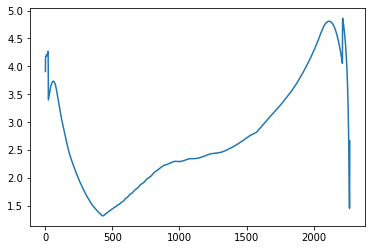

In [9]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots()
#ax1.plot(test.LV4.dt[:])
#ax1.plot(test.LV4.error)
#axs.plot(test.Ma)
ax1.plot([state[2][3][3] for state in test.states[1:]])
plt.show()
